In [2]:
from coralModel import Reef
from coralModel import Organism
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import tools as tl

from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

from ripser import ripser, lower_star_img
from persim import plot_diagrams
from scipy import ndimage
import PIL
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition 

In [108]:
## Parameters
NumberOfSimulations = 100
dt=.1
tf=30

coralPercent = .5
algaePercent = .25
r=1.0
d=.2
a=.2
g=.8
y=.9
threshold = 5

rows = 10
columns = 10

## Set up based on above
NumberOfRuns = int(tf/dt)
turfPercent = 1 - coralPercent - algaePercent
NumberOfNodes = rows * columns
coralCount = np.zeros((NumberOfRuns, NumberOfSimulations))
turfCount = np.zeros((NumberOfRuns, NumberOfSimulations))
algaeCount = np.zeros((NumberOfRuns, NumberOfSimulations))
types = np.zeros((NumberOfRuns, NumberOfNodes, NumberOfSimulations))

## Run Model with new grid each run

for s in range(0,NumberOfSimulations):
#Generate square 8x8 reef with randomly assigned types
#0 = Coral, 1 = Turf, 2 = Algae
    Moorea = Reef()
    count = 0
    for i in range(0,rows):
        for j in range(0, columns):
            U = np.random.choice([0,1,2],
                                 p=[coralPercent, turfPercent, algaePercent])
            node = Organism(type=U, location=[i,j], ID=count)
            Moorea.append(node)
            count = count + 1
    Moorea.generateGraph(threshold)
    #NumberOfNodes = count

#Run model
    for n in range(0,NumberOfRuns):
        for i,val in enumerate(Moorea.nodes):
            types[n,i,s] = Moorea.nodes[i].type
        coralCount[n,s] = np.count_nonzero(types[n,:,s] == 0)
        turfCount[n,s] = np.count_nonzero(types[n,:,s] == 1)
        algaeCount[n,s] = np.count_nonzero(types[n,:,s] == 2)
        Moorea.roll(r=r, d=d, a=a, g=g, y=y, dt=dt)


In [4]:
def binaryizer(df):
    with np.errstate(divide='ignore',invalid='ignore'):
        df = np.nan_to_num(df/df)
    return(df)
    
def shaper(df, rows):
    df = np.reshape(df, (-1, rows))
    return(df)

def tda_prep(df, columns, rows):
    df = binaryizer(df)
    dfi = 1-df
    
    df = shaper(df,rows)
    dfi = shaper(dfi,rows)
    return(df,dfi)

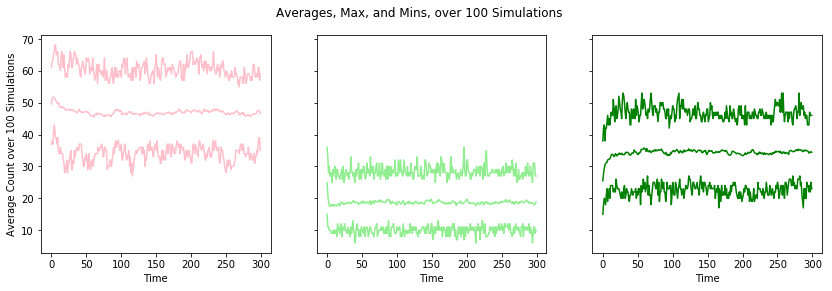

In [109]:
%matplotlib inline

fig, (ax, ax2, ax3) = plt.subplots(1,3, facecolor = 'w', sharey='row', figsize=(14, 4))
x = np.arange(300)
im = ax.plot(x, coralCount.mean(axis=1)[0:300], color='pink')
im = ax.plot(x, coralCount.max(axis=1)[0:300], color='pink')
im = ax.plot(x, coralCount.min(axis=1)[0:300], color='pink')

im2 = ax2.plot(x, turfCount.mean(axis=1)[0:300], color='lightgreen')
im2 = ax2.plot(x, turfCount.max(axis=1)[0:300], color='lightgreen')
im2 = ax2.plot(x, turfCount.min(axis=1)[0:300], color='lightgreen')

im2 = ax3.plot(x, algaeCount.mean(axis=1)[0:300], color='green')
im2 = ax3.plot(x, algaeCount.max(axis=1)[0:300], color='green')
im2 = ax3.plot(x, algaeCount.min(axis=1)[0:300], color='green')


fig.suptitle("Averages, Max, and Mins, over 100 Simulations")
ax.set_ylabel("Average Count over 100 Simulations")
ax.set_xlabel("Time")
ax2.set_xlabel("Time")
ax3.set_xlabel("Time")
ax.set_facecolor('white')
ax2.set_facecolor('white')
ax3.set_facecolor('white')
plt.savefig('write-up-1.5/Averages_g8.png')

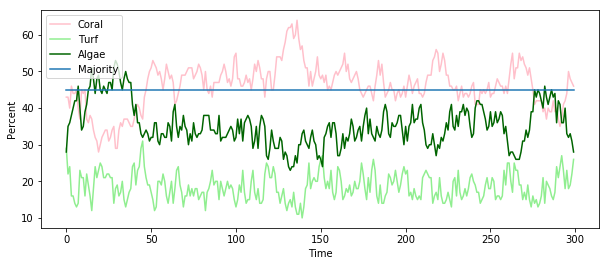

In [110]:
run = 65
x = np.arange(NumberOfRuns)
x1=coralCount[:,run]
x2=turfCount[:,run]
x3=algaeCount[:,run]

legend1='Coral'
legend2='Turf'
legend3='Algae'
legend4='Majority'
fig1 = plt.figure(figsize=(10, 4))
im = plt.plot(x, x1, color='pink')
im2 = plt.plot(x, x2, color='lightgreen')
im2 = plt.plot(x, x3, color='darkgreen')
im2 = plt.plot(x,np.repeat(45, NumberOfRuns))
plt.legend([legend1, legend2, legend3, legend4], loc='upper left', fontsize = 'medium')
plt.ylabel("Percent")
plt.xlabel("Time")
#plt.show()
plt.savefig('time_series_switchingShort.png')

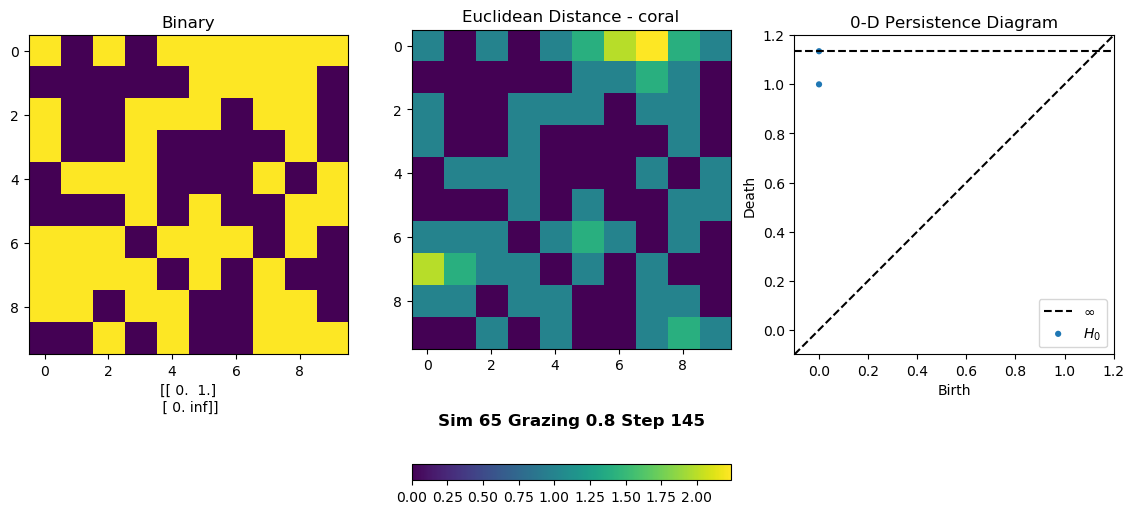

In [127]:
run = 145
simulation = 65
gg = 8


data, datai = tda_prep(types[run,:,simulation], columns, rows)
euclidean = ndimage.distance_transform_edt(data)
dgm = lower_star_img(euclidean)
                     
plt.figure(figsize=(14,10))
                     
plt.subplot(131)
plt.imshow(data)
plt.title("Binary")

plt.xlabel(str(dgm))
                     
plt.subplot(132)
plt.imshow(euclidean)
plt.colorbar(orientation="horizontal")
plt.title("Euclidean Distance - coral")

plt.xlabel("\n"+ "\n"+'Sim '+str(simulation)+' Grazing '+ str(g) + ' Step ' + str(run), fontsize=12, fontweight = 'bold')


plt.subplot(133)
plot_diagrams(dgm)
plt.title("0-D Persistence Diagram")
plt.tight_layout

plt.savefig("write-up-1.5/"+"HighSim"+str(simulation)+"Grazing"+str(gg))



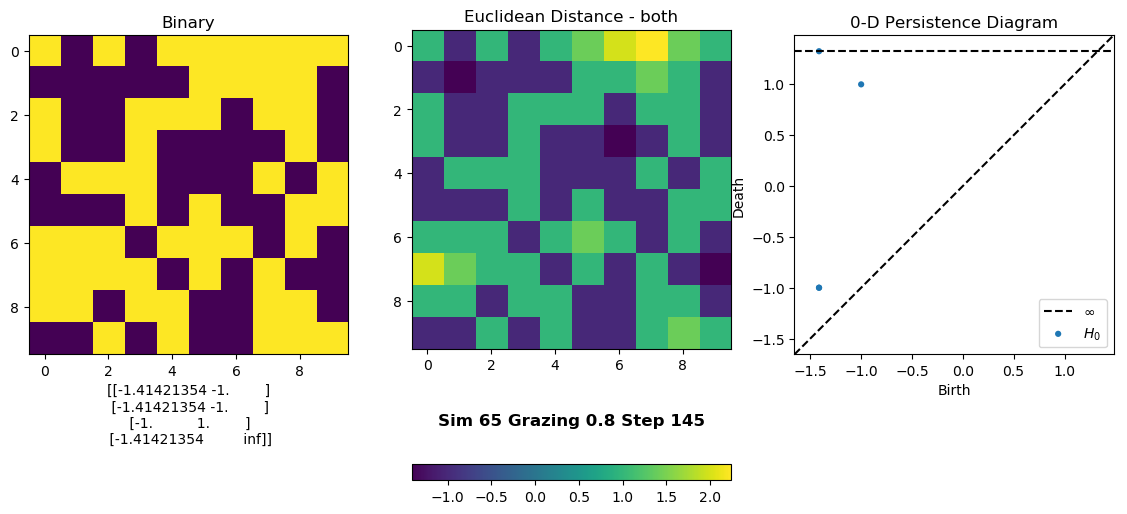

In [128]:
run = 145
simulation = 65
gg = 8

data, datai = tda_prep(types[run,:,simulation], columns, rows)
euclidean = ndimage.distance_transform_edt(data)
euclidean_i = ndimage.distance_transform_edt(datai)

combined = euclidean-euclidean_i

dgm = lower_star_img(combined)

plt.figure(figsize=(14,10))
plt.subplot(131)
plt.imshow(data)
plt.title("Binary")
plt.xlabel(str(dgm))
plt.subplot(132)
plt.imshow(combined)
plt.colorbar(orientation="horizontal")
plt.title("Euclidean Distance - both")
plt.xlabel("\n"+ "\n"+'Sim '+str(simulation)+' Grazing '+ str(g) + ' Step ' + str(run), fontsize=12, fontweight = 'bold')
plt.subplot(133)
plot_diagrams(dgm)
plt.title("0-D Persistence Diagram")
plt.tight_layout
plt.savefig("write-up-1.5/"+"both"+"HighSim"+str(simulation)+"Grazing"+str(gg))
